In [18]:
from sklearn.model_selection import train_test_split
from models.FCN import FCN7
import librosa
import numpy as np
from torchinfo import summary
from torch import nn
from torch.optim import Adam
from Utils import read_data,create_dataloader, k_fold_cross_validation, train, test
import matplotlib.pyplot as plt

# Read Data 

In [19]:
sr = 16*1000
x,y,min_length = read_data(root='../Data/genres_original', sr=sr)
print("finsh reading data")

finsh reading data


# Conversion, Compression and Normalisation

In [21]:
top_db = 80
for i in range(len(x)):
    signal = x[i][:min_length]
    mel_spect = librosa.feature.melspectrogram(y=signal,sr=sr,n_fft=2048,hop_length=512) # convert signals to mel spectrogram
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max, top_db=top_db) # log compression
    x[i] = mel_spect/-top_db # normalisation
print("finish conversion and compression")

finish conversion and compression


# Split Data

In [22]:
x = np.asarray(x)
x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
y = np.asarray(y)
print(x.shape)

(1000, 1, 128, 936)


In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    stratify=y,shuffle=True)
# k-fold cross validation
k = 5
xs_train, ys_train, xs_valid, ys_valid = k_fold_cross_validation(x_train,y_train,k)
print("finish splitting data")

finish splitting data


In [6]:
batch_size = 16
dataloaders_train = []
dataloaders_valid = []
for i in range(k):
    dataloaders_train.append(create_dataloader(xs_train[i], ys_train[i], batch_size=batch_size))
    dataloaders_valid.append(create_dataloader(xs_valid[i], ys_valid[i], batch_size=batch_size))
dataloader_test = create_dataloader(x_test, y_test, batch_size=batch_size)
print("finish creating dataloaders")

finish creating dataloaders


# Model Construction

In [7]:
model = FCN7(10)
model.cuda()
loss_function = nn.CrossEntropyLoss()
opt = Adam(model.parameters(), lr=0.001)
summary(model,[(batch_size,1,x.shape[2],x.shape[3])])

Layer (type:depth-idx)                   Output Shape              Param #
FCN7                                     [16, 10]                  --
├─ConvBlock: 1-1                         [16, 128, 128, 936]       --
│    └─Conv2d: 2-1                       [16, 128, 128, 936]       1,280
│    └─BatchNorm2d: 2-2                  [16, 128, 128, 936]       256
│    └─ReLU: 2-3                         [16, 128, 128, 936]       --
├─MaxPool2d: 1-2                         [16, 128, 64, 234]        --
├─ConvBlock: 1-3                         [16, 256, 64, 234]        --
│    └─Conv2d: 2-4                       [16, 256, 64, 234]        295,168
│    └─BatchNorm2d: 2-5                  [16, 256, 64, 234]        512
│    └─ReLU: 2-6                         [16, 256, 64, 234]        --
├─MaxPool2d: 1-4                         [16, 256, 32, 58]         --
├─ConvBlock: 1-5                         [16, 512, 32, 58]         --
│    └─Conv2d: 2-7                       [16, 512, 32, 58]         1,180,16

# Train

In [8]:
epoch = 10
history = train(model,loss_function,opt,dataloaders_train,dataloaders_valid,k,epoch=epoch)
print("finish training")

-------epoch  1 -------
fold 1:
train set loss: 2.161574739217758
train set accuracy: 0.3343749940395355
valid set loss: 2.259420371055603
valid set accuracy: 0.14374999701976776
fold 2:
train set loss: 2.086694484949112
train set accuracy: 0.4390625059604645
valid set loss: 2.113863706588745
valid set accuracy: 0.3499999940395355
fold 3:
train set loss: 2.0519272476434707
train set accuracy: 0.4906249940395355
valid set loss: 2.1039407730102537
valid set accuracy: 0.30000001192092896
fold 4:
train set loss: 2.037781623005867
train set accuracy: 0.5390625
valid set loss: 2.0566587448120117
valid set accuracy: 0.40625
fold 5:
train set loss: 2.027223238348961
train set accuracy: 0.5531250238418579
valid set loss: 2.033651852607727
valid set accuracy: 0.4437499940395355
epoch loss: 2.114
epoch accuracy: 0.329
-------epoch  2 -------
fold 1:
train set loss: 1.9895029574632646
train set accuracy: 0.621874988079071
valid set loss: 1.9784559249877929
valid set accuracy: 0.5625
fold 2:
train 

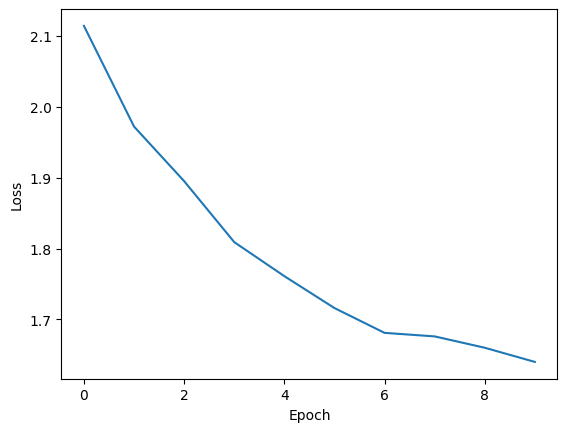

In [9]:
plt.plot(range(epoch),history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

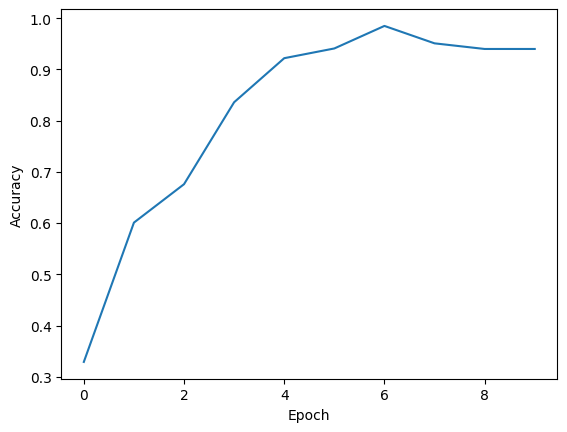

In [10]:
plt.plot(range(epoch),history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Test

In [11]:
loss, acc, AUC, f1 = test(model,loss_function,dataloader_test)

test set loss: 1.792
test set accuracy: 0.76
test set AUC: 0.861
test set f1-score: 0.76
